# Este projeto foi o Trabalho Final da disciplina de Séries Temporais do curso Ciência de Dados para Negócios da Alumni COPPEAD

## Dados
Os dados escolhidos são [dados climáticos diários da Austrália](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) entre os anos 2008 e 2017. Neste trabalho serão analisados apenas os dados da cidade de WaggaWagga entre os anos de 2014 a 2016.

## Objetivo
O objetivo deste trabalho é realizar a análise da série temporal da Temperatura medida às 3PM, bem como realizar uma previsão destas temperaturas para o próximo ano (2017).

In [ ]:
# Bibliotecas padroes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import statsmodels.api as sm

# Funcoes de series temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss

from statsmodels.api import OLS

In [ ]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
# prompt: Agrupa df por Location somando o número de nulos na coluna Temp3pm em cada Location e seleciona apenas os que tem 0 nulos

df_temp3pm_nulls = df.groupby('Location')['Temp3pm'].apply(lambda x: x.isnull().sum()).reset_index(name='Temp3pm_Nulls')
df_locations_no_nulls = df_temp3pm_nulls[df_temp3pm_nulls['Temp3pm_Nulls'] == 0]

print(df_locations_no_nulls)


            Location  Temp3pm_Nulls
8             Cairns              0
19  MelbourneAirport              0
21             Moree              0
39        Townsville              0
42        WaggaWagga              0
44          Watsonia              0


A Cidade escolhida foi WaggaWagga devido à ausência de nulos na coluna de Temp3pm

In [ ]:
# Seleciona apenas a cidade de Sydney
df_city = df[df['Location'] == 'WaggaWagga']

# Seleciona apenas as colunas Data e Temp3pm
df_temp = df_city[['Date', 'Temp3pm']]

# Transforma campo Date em data
df_temp['Date'] = pd.to_datetime(df_temp['Date'])

# Renomeia Temp3pm por temp
df_temp.rename(columns={'Temp3pm': 'temp', 'Date': 'date'}, inplace=True)

# Seleciona apenas anos de 2014 a 2016
df_filtered = df_temp.loc[df_temp['date'].between('2014-01-01','2016-12-31')]

# Substitui valores nulos pela mediana
# df_filtered['temp'] = df_filtered.fillna(df_filtered['temp'].median())

# Seta coluna date como index
df_filtered.set_index('date', inplace=True)

<ipython-input-6-5da57015d1b0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Date'] = pd.to_datetime(df_temp['Date'])
<ipython-input-6-5da57015d1b0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.rename(columns={'Temp3pm': 'temp', 'Date': 'date'}, inplace=True)


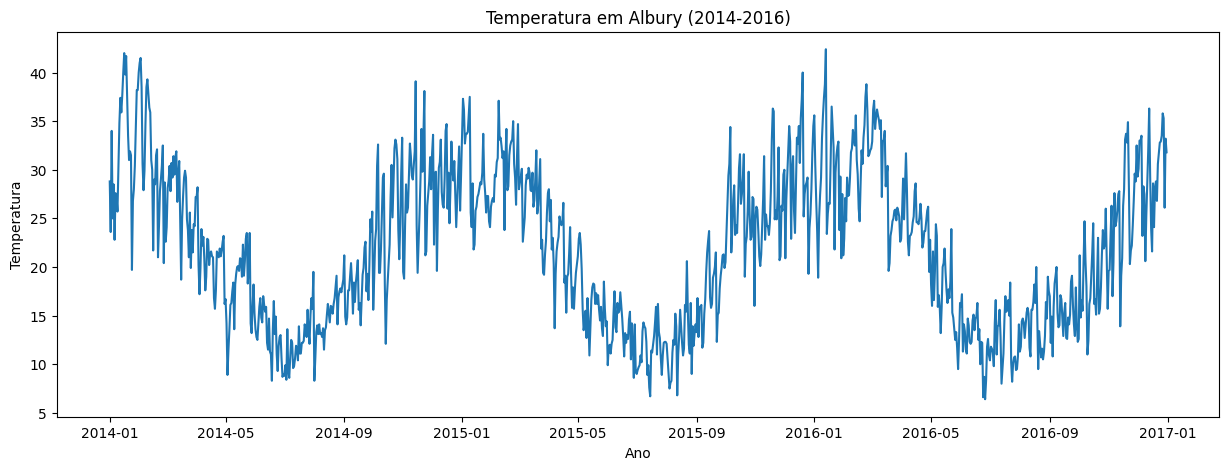

In [ ]:
# Plota os dados
plt.figure(figsize=(15, 5))
plt.plot(df_filtered.index, df_filtered['temp'])
plt.xlabel('Ano')
plt.ylabel('Temperatura')
plt.title('Temperatura em WaggaWagga (2014-2016)')
plt.show()

In [ ]:
# Teste de estacionaridade
def teste_adf(serie, nome):
    resultado = adfuller(serie, regression = "n")
    print(f'Teste ADF para {nome}:')
    print(f'Estatística ADF: {resultado[0]}')
    print(f'Valor-p: {resultado[1]}')
    print(f'Nº de lags usados: {resultado[2]}')
    print(f'Nº de observações usadas para o cálculo: {resultado[3]}')
    for chave, valor in resultado[4].items():
        print(f'Valor crítico {chave}: {valor}')
    print('')

In [ ]:
# Teste ADF
teste_adf(df_filtered['temp'], 'Temperatura')

Teste ADF para Temperatura:
Estatística ADF: -0.8211890406797373
Valor-p: 0.3616362248811096
Nº de lags usados: 18
Nº de observações usadas para o cálculo: 1077
Valor crítico 1%: -2.567819078633261
Valor crítico 5%: -1.9412522725177879
Valor crítico 10%: -1.6165757085385368



Como o p-valor > 5%, não podemos rejeitar a hipótese nula de que a série não é estacionária. Desta forma, se faz necessário tratar a série para deixá-la estacionária. Para isso, será feita a diferenciação da série a seguir.

In [ ]:
# Diferencia os dados e os adiciona em uma nova coluna: temp_diff
df_filtered['temp_diff'] = df_filtered['temp'].diff()

# Remove os valores nulos
df_filtered.dropna(inplace=True)

# Refazendo o teste adf Teste ADF
teste_adf(df_filtered['temp_diff'], 'Temperatura')

Teste ADF para Temperatura:
Estatística ADF: -11.853508053943587
Valor-p: 1.3726727464901583e-21
Nº de lags usados: 14
Nº de observações usadas para o cálculo: 1080
Valor crítico 1%: -2.5678132947530865
Valor crítico 5%: -1.9412515638630101
Valor crítico 10%: -1.6165763807568714



<ipython-input-10-84f65ec2348a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['temp_diff'] = df_filtered['temp'].diff()
<ipython-input-10-84f65ec2348a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(inplace=True)


Agora o p-valor << 5%, podemos rejeitar a hipótese de não estacionaridade e considerar a série estacionária

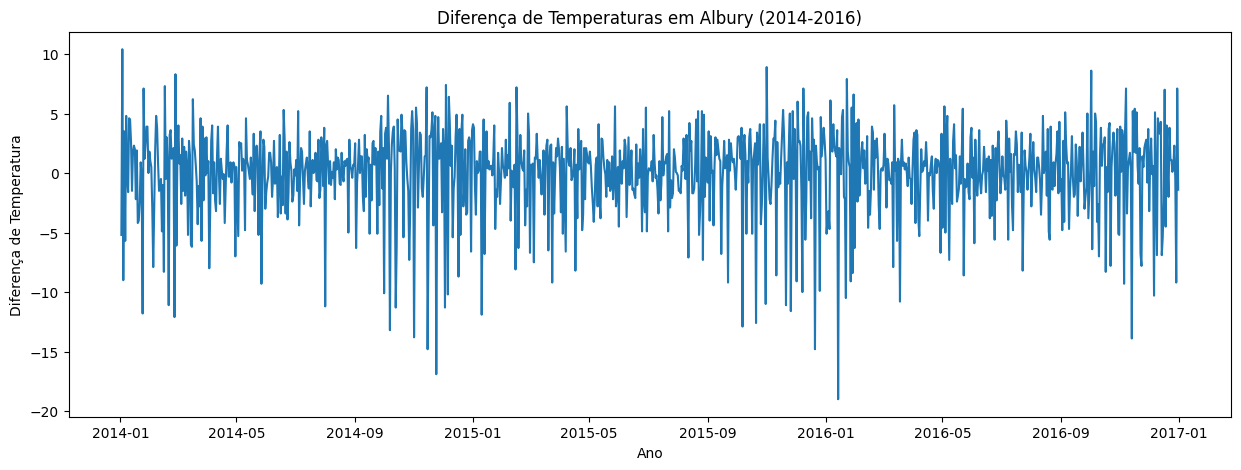

In [ ]:
# Plota os dados
plt.figure(figsize=(15, 5))
plt.plot(df_filtered.index, df_filtered['temp_diff'])
plt.xlabel('Ano')
plt.ylabel('Diferença de Temperatura')
plt.title('Diferença de Temperaturas em Albury (2014-2016)')
plt.show()

In [ ]:
# Função que plota a FAC e FACP
def plot_acf_pacf(serie, lags=15):

  # FAC
  plt.figure(figsize=(1, 4))
  plot_acf(serie, lags=lags, alpha=0.05, zero=False)
  plt.title('Função de Autocorrelação (FAC)')
  plt.xlabel('Defasagem (Lag)')
  plt.ylabel('Autocorrelação')
  plt.xticks(range(1, lags+1, 1))
  plt.grid(axis='x', which='both')
  plt.show()

  # FACP
  plt.figure(figsize=(10,4))
  plot_pacf(serie, lags=lags, alpha=0.05, zero=False)
  plt.title('Função de Autocorrelação Parcial (FACP)')
  plt.xlabel('Defasagem (Lag)')
  plt.ylabel('Autocorrelação')
  plt.xticks(range(1, lags+1, 1))
  plt.grid(axis='x', which='both')
  plt.show()

<Figure size 100x400 with 0 Axes>

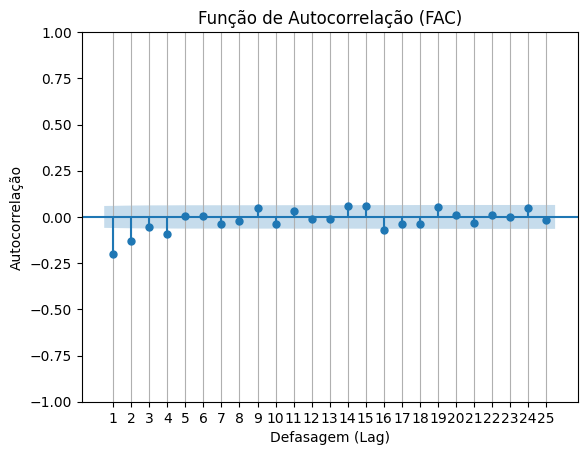

<Figure size 1000x400 with 0 Axes>

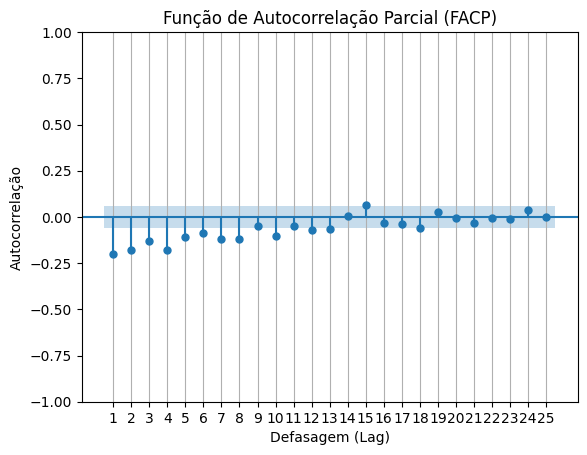

In [ ]:
# Plota FAC e FACP do processo
plot_acf_pacf(df_filtered['temp_diff'], 25)

Como não é possível identificar claramente o processo como sendo Autoregressivo(AR) ou de Média Móvel(MA), visto que a FAC e a FACP são semelhantes em comportamento, e não sendo possível identificar alguma sazonalidade, o processo deve ser Misto de uma série não estacionária, que precisou ser diferenciada uma vez para rejeitarmos H0, ou seja, um processo ARIMA com d=1

Para descobrir as ordens *p* e *q*, será construído o mapa de calor BIC a seguir

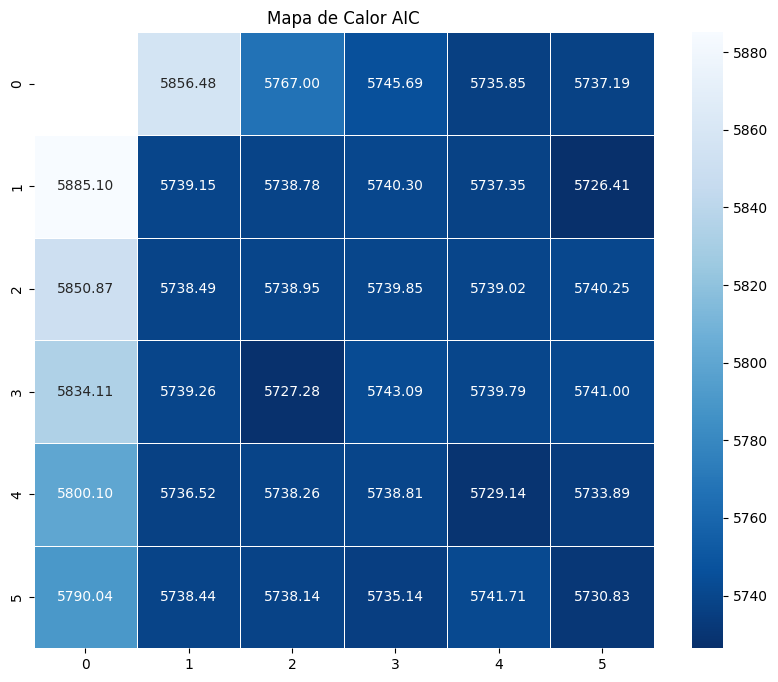

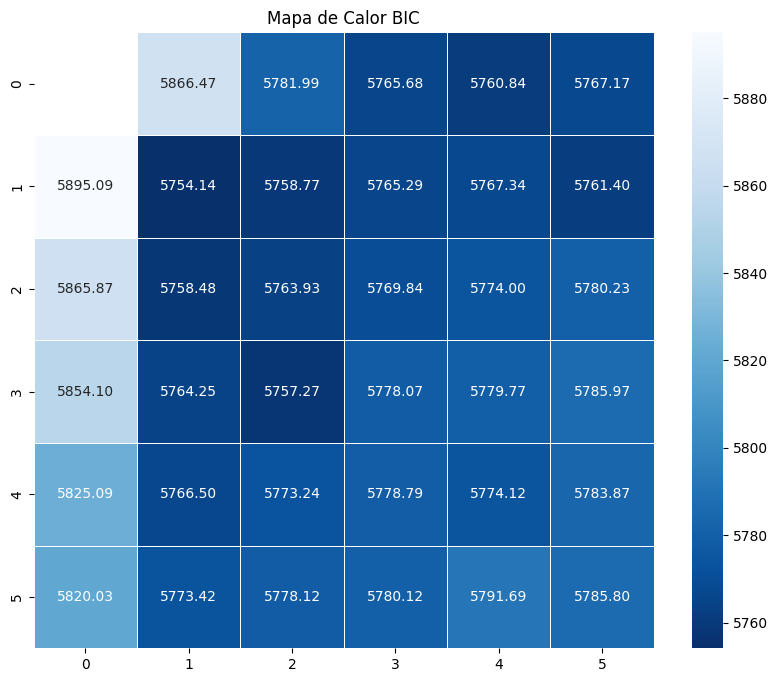

In [ ]:
import warnings

bic = pd.DataFrame(np.zeros((6,6), dtype=float))
aic = pd.DataFrame(np.zeros((6,6), dtype=float))

warnings.simplefilter('ignore')

# Iterar sobre modelos ARIMA(p,1,q) com p,q em [0,6]
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        # Estimação dos modelos
        mod = ARIMA(df_filtered['temp'], order=(p, 1, q))
        try:
            res = mod.fit()
            bic.iloc[p,q] = res.bic
            aic.iloc[p,q] = res.aic
        except:
            bic.iloc[p,q] = np.nan
            aic.iloc[p,q] = np.nan

bic.iloc[0,0] = np.nan
aic.iloc[0,0] = np.nan

# Plotando o mapa de calor AIC
plt.figure(figsize=(10, 8))
sns.heatmap(aic, annot=True, fmt=".2f", cmap='Blues_r', linewidths=.5)
plt.title("Mapa de Calor AIC")
plt.show()

# Plotando o mapa de calor BIC
plt.figure(figsize=(10, 8))
sns.heatmap(bic, annot=True, fmt=".2f", cmap='Blues_r', linewidths=.5)
plt.title("Mapa de Calor BIC")
plt.show()

De acordo com o mapa de calor de critério de informação de Schwarz (BIC), o melhor modelo para este caso é o modelo ARIMA(1,1,1) com parte AR(1) e parte MA(1)

In [ ]:
model = ARIMA(df_filtered['temp'], order=(1, 1, 1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                 1095
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2866.575
Date:                Tue, 01 Oct 2024   AIC                           5739.151
Time:                        12:59:52   BIC                           5754.143
Sample:                    01-02-2014   HQIC                          5744.824
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5161      0.038     13.460      0.000       0.441       0.591
ma.L1         -0.8914      0.021    -42.180      0.000      -0.933      -0.850
sigma2        11.0459      0.385     28.721      0.0

Ambos os coeficientes são estatísticamente significantes.

O teste de Jarque-Bera teve a hipótese de normalidade rejeitada, porém como este é um problema de previsão, a não normalidade não é considerada grave, mas implica que as inferências podem ser impactadas em modelos que assumem a normalidade dos dados, como o modelo em questão (ARIMA).

A seguir, serão feitos os diagnósticos sobre os resíduos.

## Diagnósticos

### Normalidade dos resíduos

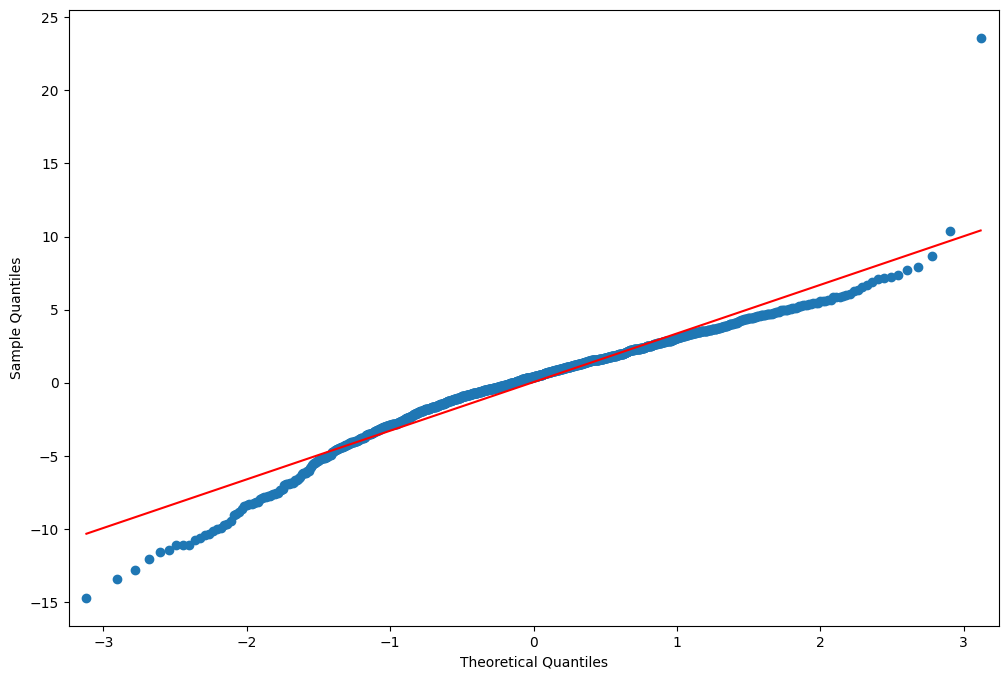

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = sm.graphics.qqplot(results.resid, line="r", ax=ax)

A hipótese da normalidade dos resíduos não parece verdadeira, visto o afastamento dos pontos iniciais da reta, embora tenha maior parte dos pontos em torno da reta.

<Figure size 100x400 with 0 Axes>

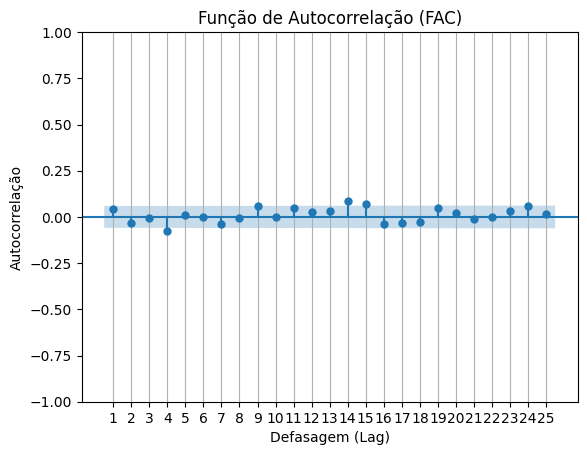

<Figure size 1000x400 with 0 Axes>

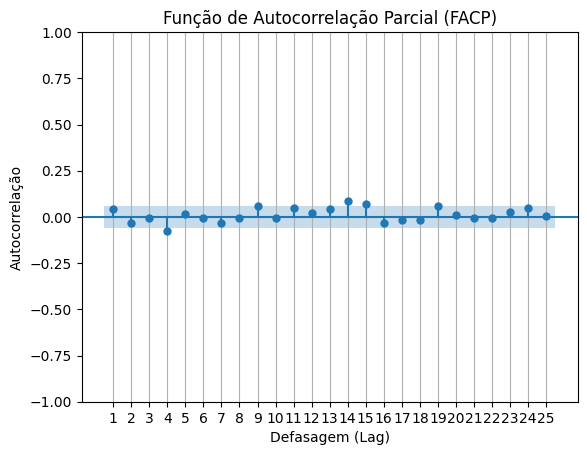

In [ ]:
plot_acf_pacf(results.resid, 25)

O modelo foi próximo de explicar a estrutura de autocorrelação da série, uma vez que seus resíduos apresentam dependência linear significativa, por pouco, em apenas 3 lags (4, 14 e 15).

### Teste de Box-Ljung

In [ ]:
r, q, p = sm.tsa.acf(results.resid.values.squeeze(), fft=True, qstat=True)
data = np.c_[np.arange(1, 31), r[1:], q, p]

table = pd.DataFrame(data, columns=["lag", "AC", "Q", "Prob(>Q)"])
table['lag'] = table['lag'].astype(int)
table['Prob(>Q)'] = table['Prob(>Q)'].round(3)
table.set_index("lag")
print(table[:31])

    lag        AC          Q  Prob(>Q)
0     1  0.042486   1.981925     0.159
1     2 -0.031740   3.089061     0.213
2     3 -0.005986   3.128481     0.372
3     4 -0.075074   9.333987     0.053
4     5  0.008093   9.406164     0.094
5     6  0.000615   9.406582     0.152
6     7 -0.035597  10.805591     0.147
7     8 -0.003745  10.821086     0.212
8     9  0.057208  14.441020     0.107
9    10  0.000234  14.441080     0.154
10   11  0.048178  17.013206     0.107
11   12  0.024886  17.700113     0.125
12   13  0.031682  18.814430     0.129
13   14  0.087359  27.294654     0.018
14   15  0.067464  32.356865     0.006
15   16 -0.037259  33.902317     0.006
16   17 -0.031354  34.997747     0.006
17   18 -0.029781  35.986924     0.007
18   19  0.047280  38.482413     0.005
19   20  0.023748  39.112609     0.006
20   21 -0.010962  39.247001     0.009
21   22 -0.000705  39.247559     0.013
22   23  0.032292  40.416020     0.014
23   24  0.060698  44.548167     0.007
24   25  0.013786  44.761

Pelo teste de Box-Ljung, não existem evidências de autocorrelações dos resíduos até o lag 12, indicando que o modelo capturou bem a estrutura de dependência inicial da série. Entretanto, não foi capaz de capturar o restante, o que implica na má estimativa out-of-sample dos dados abaixo demonstrada.



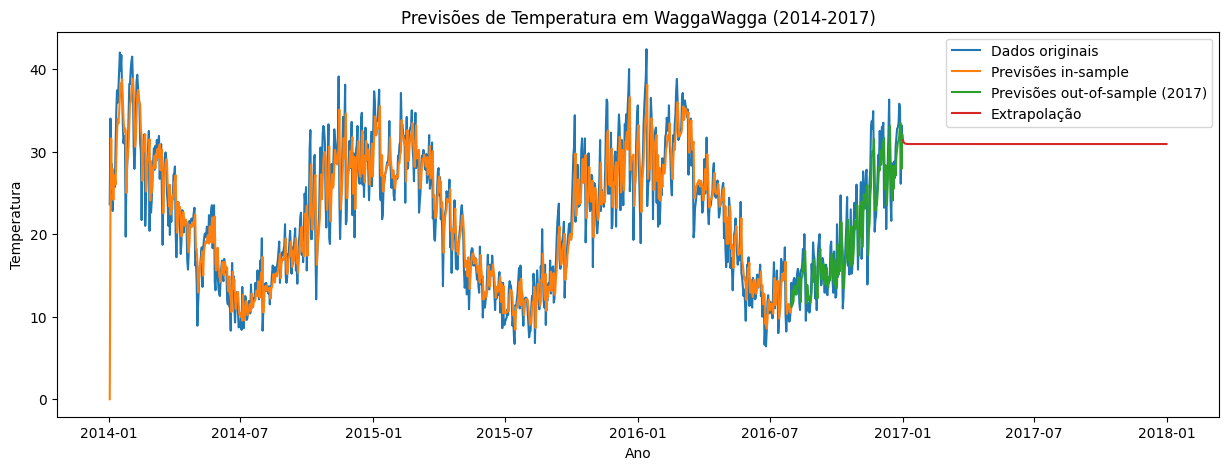

In [ ]:
# Ajuste do modelo ARIMA(1,1,1)
model = ARIMA(df_filtered['temp'], order=(1, 1, 1))
results = model.fit()

# Previsões
predictions = results.predict('2014-01-02','2017-12-31')

# Plota os resultados
plt.figure(figsize=(15, 5))
plt.plot(df_filtered['temp'], label='Dados originais')
plt.plot(predictions['2014-01-02':'2016-7-31'], label='Previsões in-sample')
plt.plot(predictions['2016-7-31':'2017-01-01'], label='Previsões out-of-sample (2017)')
plt.plot(predictions['2017-01-01':], label='Extrapolação')
plt.xlabel('Ano')
plt.ylabel('Temperatura')
plt.title('Previsões de Temperatura em WaggaWagga (2014-2017)')
plt.legend()
plt.show()

<Figure size 100x400 with 0 Axes>

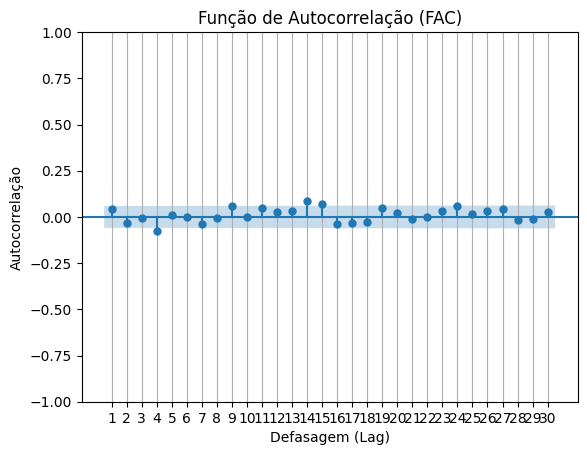

<Figure size 1000x400 with 0 Axes>

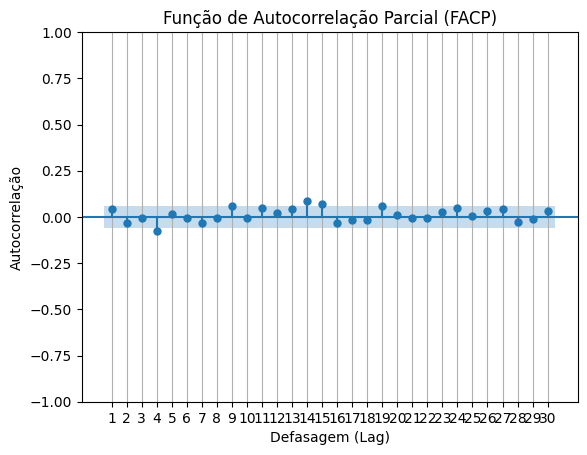

In [ ]:
# Plota FAC e FACP dos resíduos para ajustar o modelo
plot_acf_pacf(results.resid, 30)

In [ ]:
# Teste do modelo ARIMA(lag 4, d=1, lags 14-15)
model = ARIMA(df_filtered['temp'], order=([0,0,0,1], 1, [1,1,1,0,1,1,1,0,0,0,0,0,0,1,0]))
results = model.fit()

print(results.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                      temp   No. Observations:                 1095
Model:             ARIMA([4], 1, [1, 2, 3, 5, 6, 7, 14])   Log Likelihood               -2858.119
Date:                                   Tue, 01 Oct 2024   AIC                           5734.239
Time:                                           13:46:00   BIC                           5779.217
Sample:                                       01-02-2014   HQIC                          5751.259
                                            - 12-31-2016                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L4         -0.1160      0.035     -3.360      0.001    

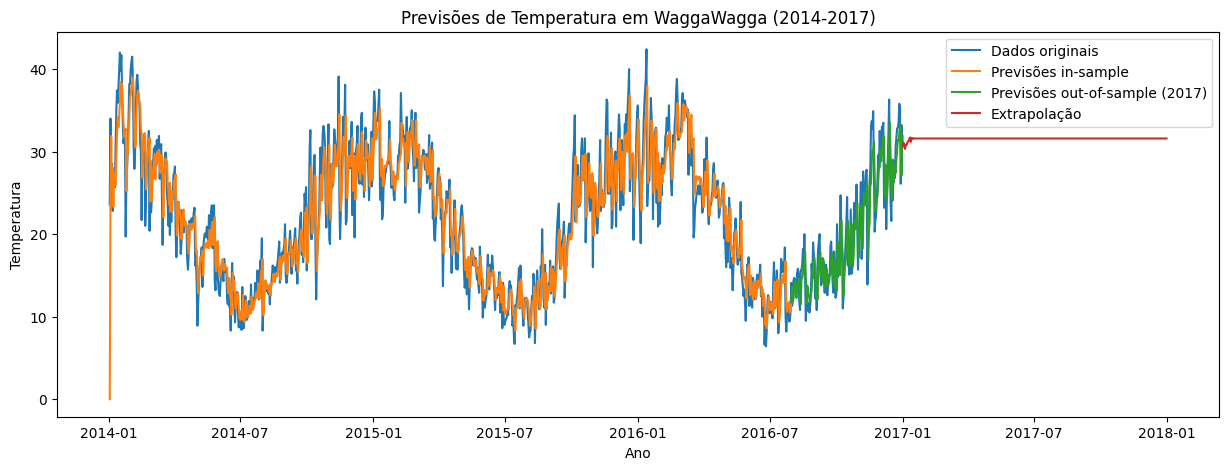

In [ ]:
# Previsões
predictions = results.predict('2014-01-02','2017-12-31')

# Plota os resultados
plt.figure(figsize=(15, 5))
plt.plot(df_filtered['temp'], label='Dados originais')
plt.plot(predictions['2014-01-02':'2016-7-31'], label='Previsões in-sample')
plt.plot(predictions['2016-7-31':'2017-01-01'], label='Previsões out-of-sample (2017)')
plt.plot(predictions['2017-01-01':], label='Extrapolação')
plt.xlabel('Ano')
plt.ylabel('Temperatura')
plt.title('Previsões de Temperatura em WaggaWagga (2014-2017)')
plt.legend()
plt.show()

<Figure size 100x400 with 0 Axes>

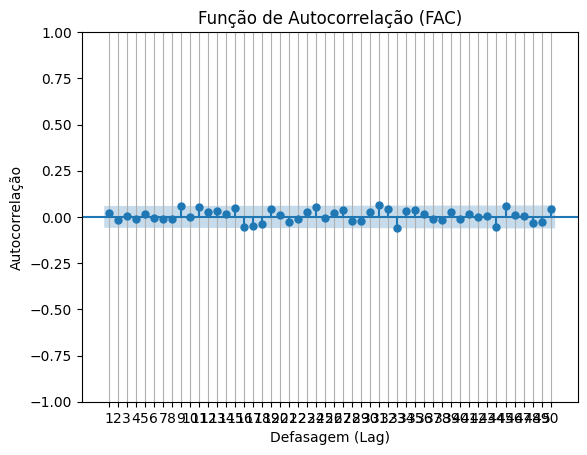

<Figure size 1000x400 with 0 Axes>

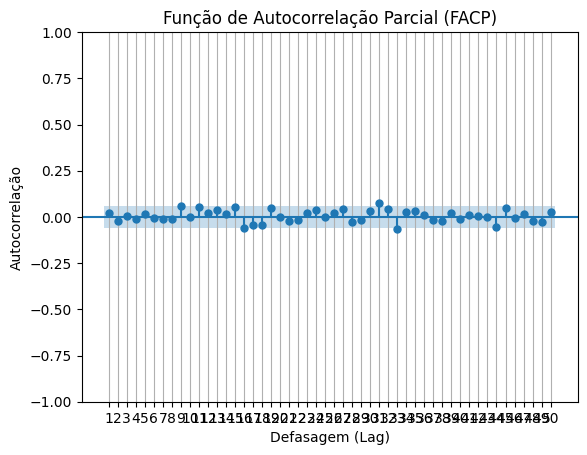

In [ ]:
plot_acf_pacf(results.resid, 50)

## Transformação dos dados
Como não foi possível encontrar o melhor modelo capaz de realizar o forecasting dos dados em questão, os dados serão transformados de diários para mensais, de forma a conseguir encontrar a sazonalidade dos dados e tratá-la.

In [ ]:
# Dados de WaggaWagga
print(df_temp.head())

# Transforma date em index
df_temp.set_index('date', inplace=True)

            date  temp
36529 2009-01-01  27.0
36530 2009-01-02  23.2
36531 2009-01-03  28.0
36532 2009-01-04  33.7
36533 2009-01-05  34.6


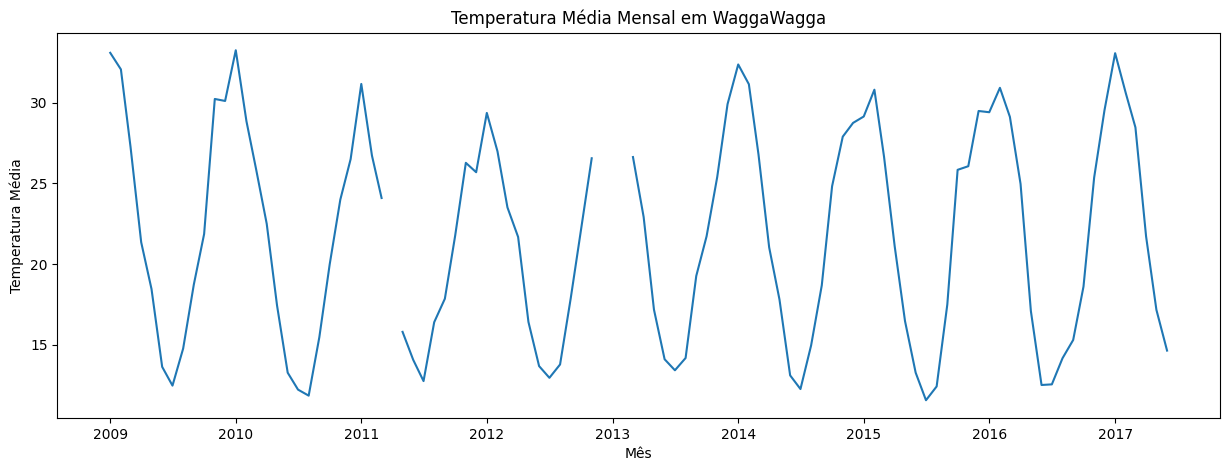

In [ ]:
# Agrupar os dados por mês e calcular a média da temperatura
df_monthly = df_temp.resample('M').mean()

# Transforma a data do index date para ano-mes
df_monthly.index = df_monthly.index.strftime('%Y-%m').astype('datetime64[ns]')

# Plotar os dados mensais
plt.figure(figsize=(15, 5))
plt.plot(df_monthly.index, df_monthly['temp'])
plt.xlabel('Mês')
plt.ylabel('Temperatura Média')
plt.title('Temperatura Média Mensal em WaggaWagga')
plt.show()


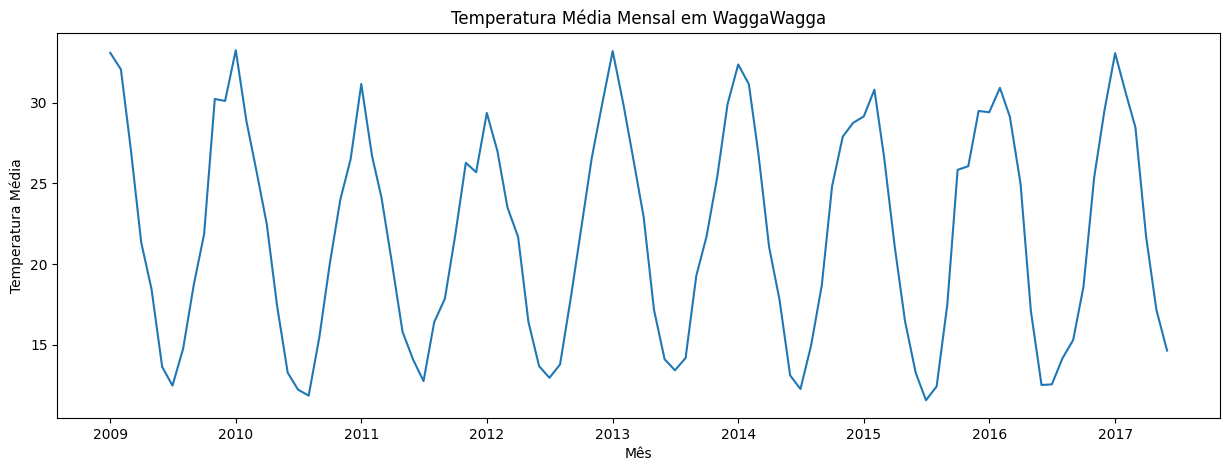

In [ ]:
# Seleciona valores nulos de df_monthly
df_null = df_monthly[df_monthly['temp'].isnull()]

# Substitui valores nulos pela média do valor anterior e o próximo
for index in df_null.index:
  previous_value = df_monthly.loc[index - pd.DateOffset(months=1), 'temp']
  next_value = df_monthly.loc[index + pd.DateOffset(months=1), 'temp']

  mean_value = (previous_value + next_value) / 2

  df_monthly.loc[index, 'temp'] = mean_value

# Plotar os dados mensais
plt.figure(figsize=(15, 5))
plt.plot(df_monthly.index, df_monthly['temp'])
plt.xlabel('Mês')
plt.ylabel('Temperatura Média')
plt.title('Temperatura Média Mensal em WaggaWagga')
plt.show()

### Teste de Estacionaridade

In [ ]:
# Teste de estacionaridade
def teste_adf_II(serie, nome):
    resultado = adfuller(serie)
    print(f'Teste ADF para {nome}:')
    print(f'Estatística ADF: {resultado[0]}')
    print(f'Valor-p: {resultado[1]}')
    print(f'Nº de lags usados: {resultado[2]}')
    print(f'Nº de observações usadas para o cálculo: {resultado[3]}')
    for chave, valor in resultado[4].items():
        print(f'Valor crítico {chave}: {valor}')
    print('')

In [ ]:
teste_adf_II(df_monthly['temp'], 'Temperatura Mensal Média')

Teste ADF para Temperatura Mensal Média:
Estatística ADF: -1.9806791882016783
Valor-p: 0.29510832145698074
Nº de lags usados: 11
Nº de observações usadas para o cálculo: 90
Valor crítico 1%: -3.505190196159122
Valor crítico 5%: -2.894232085048011
Valor crítico 10%: -2.5842101234567902



Como não podemos rejeitar a hipótese de não estacionaridade, a série será diferenciada.

In [ ]:
# Diferencia os dados e os adiciona em uma nova coluna: temp_diff
df_monthly['temp_diff'] = df_monthly['temp'].diff()

# Remove os valores nulos
df_monthly.dropna(inplace=True)

# Refazendo o teste adf Teste ADF
teste_adf(df_monthly['temp_diff'], 'Temperatura')

Teste ADF para Temperatura:
Estatística ADF: -7.558868132580896
Valor-p: 3.3185204591405394e-12
Nº de lags usados: 10
Nº de observações usadas para o cálculo: 90
Valor crítico 1%: -2.59103
Valor crítico 5%: -1.944357046639232
Valor crítico 10%: -1.6141691577503428



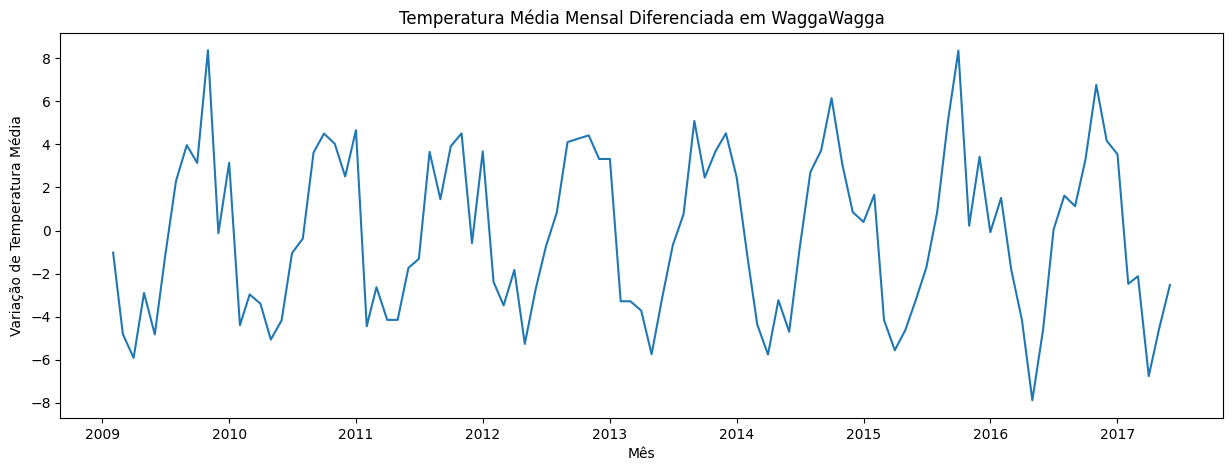

In [ ]:
# Plotar os dados mensais
plt.figure(figsize=(15, 5))
plt.plot(df_monthly.index, df_monthly['temp_diff'])
plt.xlabel('Mês')
plt.ylabel('Variação de Temperatura Média')
plt.title('Temperatura Média Mensal Diferenciada em WaggaWagga')
plt.show()

Com a série agora estacionária (p-valor < 5%), podemos plotar sua FAC e FACP para identificar o modelo

### FAC e FACP

<Figure size 100x400 with 0 Axes>

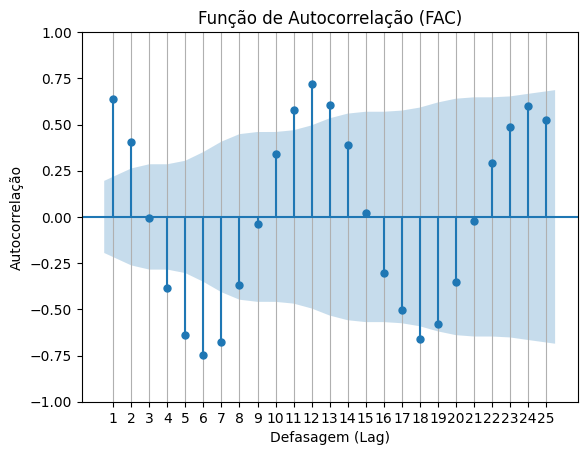

<Figure size 1000x400 with 0 Axes>

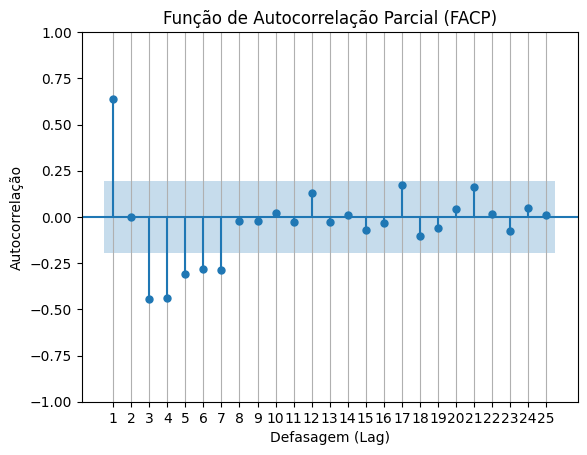

In [ ]:
plot_acf_pacf(df_monthly['temp_diff'], 25)

A FAC em formato de senóide amortecida sugere sazonalidade e, em união com a FACP com apenas os lags iniciais significativos e o restante irrelevantes, este processo parece um modelo AR de ordem 7 com o segundo lag não significativo [1,0,1,1,1,1,1].

### Sazonalidade
Partindo o modelo AR[1,0,1,1,1,1,1] com sazonalidade segundo o modelo airline.

In [ ]:
# Extraindo os meses das datas
df_monthly['month'] = df_monthly.index.month

# Criando variáveis dummies para os meses
dummies = pd.get_dummies(df_monthly['month'], prefix='month', drop_first=False, dtype='int')

# Removendo a coluna de junho (6) para usá-la como baseline
dummies_f = dummies.drop('month_12', axis=1)

# garantir alinhamento dos índices
dummies.index = df_monthly.index
dummies_f.index = df_monthly.index

# Primeiro, podemos ajustar um modelo com todas as variáveis desejadas
model_d = ARIMA(df_monthly.temp, order=([1,0,1,1,1,1,1], 1, 0), exog=dummies_f)
results = model_d.fit()

# Resumo dos resultados
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  101
Model:             ARIMA([1, 3, 4, 5, 6, 7], 1, 0)   Log Likelihood                -176.173
Date:                             Tue, 01 Oct 2024   AIC                            388.347
Time:                                     12:55:19   BIC                            435.240
Sample:                                 02-01-2009   HQIC                           407.325
                                      - 06-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month_1        2.6225      0.573      4.578      0.000       1.500       3.745
month_2        0.7730      

O modelo parece fazer sentido, uma vez que várias variáveis dummies tem p-valor < 5%. Entretanto, o modelo airline será utilizado primeiramente de forma a evitar modelos complexos demais para um problema simples. Caso seja necessário adaptar o modelo, as adaptações serão feitas para melhor adaptar o modelo aos dados.

In [ ]:
# Começando pelo modelo airline
monthly_model = ARIMA(df_monthly['temp'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
results = monthly_model.fit()
print(results.summary())

                                    SARIMAX Results                                     
Dep. Variable:                             temp   No. Observations:                  101
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -173.527
Date:                          Tue, 01 Oct 2024   AIC                            353.054
Time:                                  12:55:19   BIC                            360.486
Sample:                              02-01-2009   HQIC                           356.048
                                   - 06-01-2017                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5466      0.109     -4.994      0.000      -0.761      -0.332
ma.S.L12      -0.7860      0.122     -6.453      0.

Como o modelo airline apresenta um resultado consideravelmente razoável, serão realizados os diagnósticos do modelo para considerar novos modelos ou seguir utilizando o modelo airline para este caso.

### Normalidade dos Resíduos

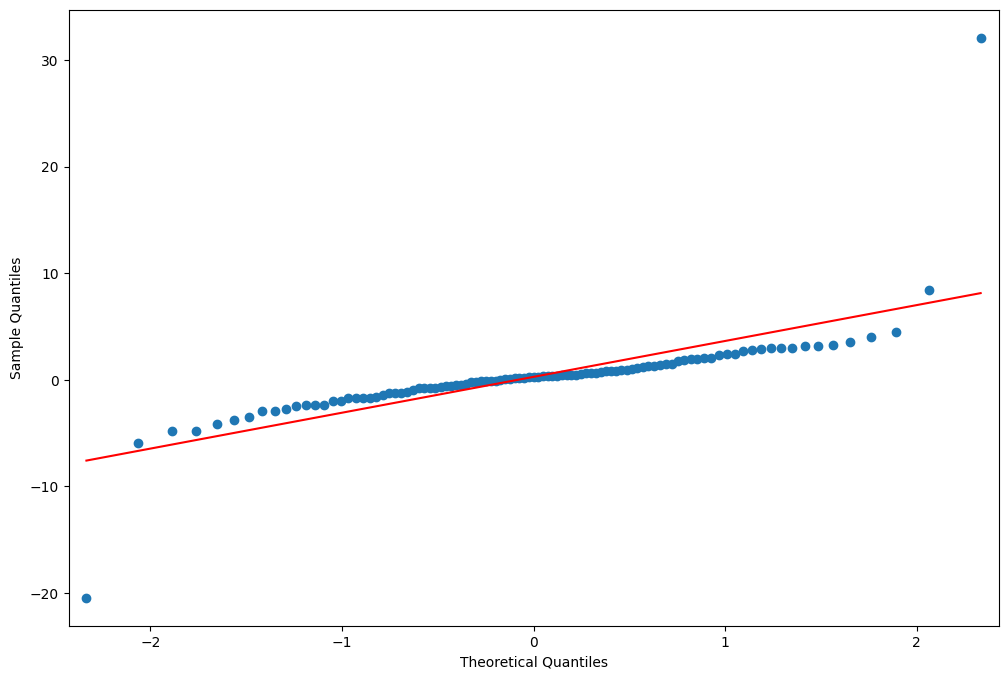

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = sm.graphics.qqplot(results.resid, line="r", ax=ax)

Os resíduos parecem normais, devido à proximidade da reta

### FAC e FACP dos resíduos

<Figure size 100x400 with 0 Axes>

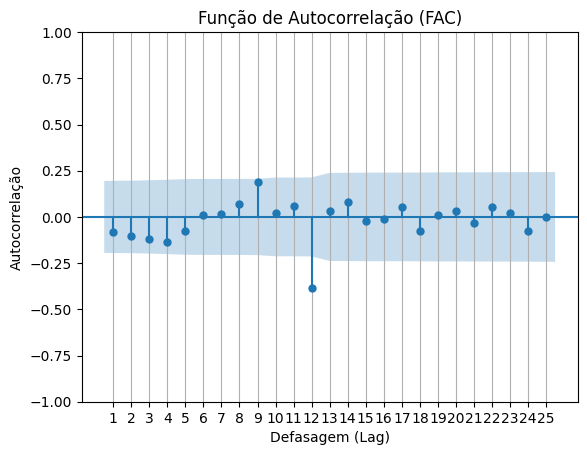

<Figure size 1000x400 with 0 Axes>

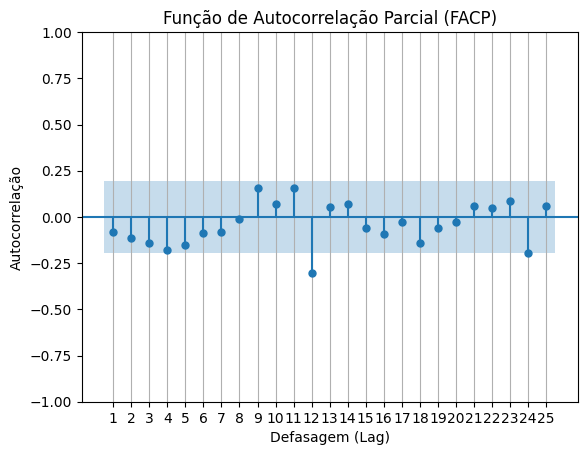

In [ ]:
plot_acf_pacf(results.resid, 25)

Como na FAC há a presença apenas do lag sazonal 12, mas não há significância no lag sazonal 24, e na FACP a sazonalidade decresce no decorrer dos lags 12 e 24, a sazonalidade se assemelha ao modelo AR(1), resultando então na ordem sazonal (1,0,0,12) para o modelo

In [ ]:
#Gerar o teste de Box-Ljung para resídos do modelo SARIMA

r, q, p = sm.tsa.acf(results.resid.values.squeeze(), fft=True, qstat=True)
data = np.c_[np.arange(1, 21), r[1:], q, p]

table = pd.DataFrame(data, columns=["lag", "AC", "Q", "Prob(>Q)"])
table['lag'] = table['lag'].astype(int)
table['Prob(>Q)'] = table['Prob(>Q)'].round(3)
table.set_index("lag")
print(table[:25])

    lag        AC          Q  Prob(>Q)
0     1 -0.028950   0.087188     0.768
1     2 -0.097375   1.083548     0.582
2     3 -0.085196   1.854047     0.603
3     4 -0.171562   5.010715     0.286
4     5 -0.100817   6.112146     0.295
5     6 -0.021021   6.160536     0.405
6     7 -0.015717   6.187875     0.518
7     8  0.054500   6.520122     0.589
8     9  0.143535   8.849755     0.451
9    10  0.020973   8.900041     0.542
10   11  0.089771   9.831563     0.546
11   12 -0.161892  12.895059     0.377
12   13  0.066191  13.412988     0.416
13   14  0.101499  14.644856     0.403
14   15 -0.059468  15.072641     0.446
15   16  0.015511  15.102087     0.517
16   17  0.034860  15.252585     0.577
17   18 -0.101966  16.555723     0.554
18   19  0.002712  16.556656     0.620
19   20  0.019265  16.604320     0.678


O modelo parece explicar bem os dados, com nenhum resíduo apresentando dependência linear significativa pela FAC e FACP.

Além disso, não podemos rejeitar a normalidade dos resíduos com o teste de Box-Ljung (Prob(Q)>5%), o que favorece a normalidade; e a Heterocedasticidade também não pode ser rejeitada (Prob(H)>5%)

In [ ]:
# Modelo escolhido
monthly_model = ARIMA(df_monthly['temp'], order=(0, 1, 1), seasonal_order=(1, 0, 0, 12))
results = monthly_model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              temp   No. Observations:                  101
Model:             ARIMA(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -221.186
Date:                           Tue, 01 Oct 2024   AIC                            448.371
Time:                                   14:01:13   BIC                            456.187
Sample:                               02-01-2009   HQIC                           451.534
                                    - 06-01-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1448      0.087     -1.673      0.094      -0.314       0.025
ar.S.L12       0.8834      0.040     22.260

## Previsões

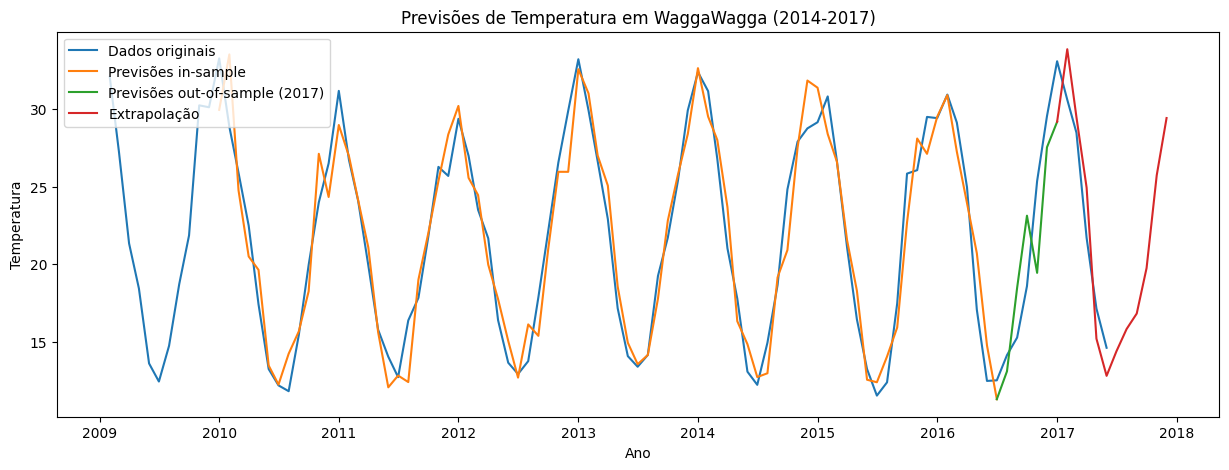

In [ ]:
# Previsões
predictions = results.predict('2010-01','2017-12')

# Plota os resultados
plt.figure(figsize=(15, 5))
plt.plot(df_monthly['temp'], label='Dados originais')
plt.plot(predictions[:'2016-7'], label='Previsões in-sample')
plt.plot(predictions['2016-7':'2017-01'], label='Previsões out-of-sample (2017)')
plt.plot(predictions['2017-01':], label='Extrapolação')
plt.xlabel('Ano')
plt.ylabel('Temperatura')
plt.title('Previsões de Temperatura em WaggaWagga (2014-2017)')
plt.legend()
plt.show()

### Medidas de Aderência

In [ ]:
## Coleta de dados in-sample (considerando o período observado)
insample_a = df_monthly['2010-1':'2016-07'].temp
insample_p = predictions['2010-1':'2016-07']

## Medidas de aderência in-sample
print("RMSE: ", np.sqrt(np.mean((insample_a - insample_p)**2)))
print("MAD: ",  np.mean(np.abs(insample_a - insample_p)))
print("MAPE: ",  np.mean(np.abs((insample_a - insample_p)/insample_a*100)))

RMSE:  1.836570507207384
MAD:  1.4740193685529415
MAPE:  7.206650266221157


In [ ]:
## Coleta de dados out-of-sample
outsample_a = df_monthly['2016-7':'2017-01'].temp
outsample_p = predictions['2016-7':'2017-01']

## Medidas de aderência out-of-sample
print("RMSE: ", np.sqrt(np.mean((outsample_a - outsample_p)**2)))
print("MAD: ",  np.mean(np.abs(outsample_a - outsample_p)))
print("MAPE: ",  np.mean(np.abs((outsample_a - outsample_p)/outsample_a*100)))

RMSE:  3.537802440346835
MAD:  3.1170034156936106
MAPE:  14.903874453650207


As medidas de aderência enfraquecem no período out-of-sample, como esperado.

Como o modelo airline foi capaz de estimar bem os dados, não se faz necessário aumentar a complexidade do modelo para o caso em questão

# Considerações Finais

Em se tratando de valores *diários* de temperatura, é possível que a sazonalidade não foi bem definida e identificada pois nem todos os meses possuem o mesmo número de dias. A sazonalidade de s=365 se mostrou irreal de utilizar devido ao desempenho do modelo preditivo (mais de 1h pra ajustar o modelo, interrompido após 1:25h sem concluir o fit).

Para a série diária, se faz necessário o estudo mais aprofundado do comportamento sazonal da série para que o modelo possa capturar melhor a variação sazonal das temperaturas no decorrer do ano.

Por conta disso a série foi transformada de diária para Média Mensal.

O resultado das predições de temperatura out-of-sample é satisfatório para a série de Médias Mensais, embora seja uma série consideravelmente mais simples do que a série diária.